### Random Forest
#### Afnan Rahman


### Importing packages and data

In [14]:
#!pip install boruta

     |████████████████████████████████| 56 kB 3.8 MB/s 


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from boruta import BorutaPy
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/afnanrahman/EAFP/main/data/clean_smote_data.csv")

### Base Model

In [3]:
X= data.drop('attrition', axis = 1)
Y = data['attrition']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [4]:
X

,age,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_number,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_with_curr_manager,rate_avg
0,41,2,1102,2,1,2,1,1,2,0,94,3,2,7,4,2,19479,8,1,11,3,1,0,8,0,1,6,4,5,6891.67
1,49,1,279,1,8,1,1,2,3,1,61,2,2,6,2,1,24907,1,0,23,4,4,1,10,3,3,10,7,7,8415.67
2,37,2,1373,1,2,2,4,4,4,1,92,2,1,2,3,2,2396,6,1,15,3,2,0,7,3,3,0,0,0,1287.00
3,33,1,1392,1,3,4,1,5,4,0,56,3,1,6,3,1,23159,1,1,11,3,3,0,8,3,3,8,7,0,8202.33
4,27,2,591,1,2,1,3,7,1,1,40,3,1,2,2,1,16632,9,0,12,3,4,1,6,3,3,2,2,2,5754.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,39,2,1053,1,7,2,2,1160,1,0,72,1,1,0,1,1,14504,4,0,13,3,1,0,12,2,2,1,0,0,5209.67
2462,32,0,453,1,11,2,3,998,3,1,43,2,1,4,1,1,10219,0,1,22,4,2,0,4,0,2,3,2,2,3571.67
2463,34,2,489,1,7,3,2,1729,3,1,59,2,2,4,1,1,5098,1,0,13,3,2,0,10,4,1,10,4,7,1882.00
2464,36,2,237,1,18,3,1,1080,1,0,49,2,1,5,2,1,11643,4,1,11,3,2,0,12,1,2,6,3,2,3976.33


In [6]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
predictions_rf = [round(value) for value in y_pred_rf]

accuracy_rf = accuracy_score(y_test, predictions_rf)
print(round(accuracy_rf*100.0 , 2))

91.08


### Manual Feature Selection

In [7]:
cols = ['job_involvement', 'job_level', 'job_role', 'job_satisfaction', 'education_field', 'performance_rating', 'total_working_years']

In [8]:
#not including target variable in X 
manual_X = data.drop('attrition', axis=1)[cols]
manual_Y = data['attrition']

In [9]:
manual_X_train, manual_X_test, manual_Y_train, manual_Y_test = train_test_split(manual_X, manual_Y, test_size=0.3, random_state=42)

In [10]:
manual_xgb = RandomForestClassifier(random_state=42)
manual_xgb.fit(manual_X_train, manual_Y_train)

RandomForestClassifier(random_state=42)

In [11]:
manual_xgb_Y_pred = manual_xgb.predict(manual_X_test)

In [12]:
manual_xgb.score(manual_X_test, manual_Y_test)

0.7851351351351351

### Feature Selection

#### Boruta

In [ ]:
feat_selector = BorutaPy(model_rf, n_estimators='auto', verbose=2, random_state=42)

In [ ]:
X_boruta = X_train.values
y_boruta = y_train.values

In [ ]:
feat_selector.fit(X_boruta, y_boruta)

In [ ]:
feat_selector.support_

array([ True,  True,  True, False,  True,  True, False,  True,  True,
       False,  True,  True,  True, False,  True, False,  True, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [ ]:
feat_selector.ranking_

array([ 1,  1,  1, 10,  1,  1,  4,  1,  1,  6,  1,  1,  1,  3,  1,  6,  1,
        5,  8,  2,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [ ]:
X_filtered = feat_selector.transform(X_boruta)

In [ ]:
model_rf.fit(X_filtered, y_train)

RandomForestClassifier(n_estimators=64,
                       random_state=RandomState(MT19937) at 0x7F1FBBD348D0)

In [ ]:
X_test_boruta = X_test.values 
X_test_flitered = feat_selector.transform(X_test_boruta)

In [ ]:
y_pred_rf = model_rf.predict(X_test_flitered)
predictions_rf = [round(value) for value in y_pred_rf]

accuracy_rf = accuracy_score(y_test, predictions_rf)
print(round(accuracy_rf*100.0 , 2))

90.54


### Hyperparameter Tuning

#### Parameter dictionary used

In [ ]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [2,4],
               'min_samples_split': [2, 5],
               'min_samples_leaf': [1, 2]}

#### Grid Search

In [ ]:
rf_best_model = GridSearchCV(estimator=model_rf, 
                   param_grid=param_grid,
                   scoring='accuracy', 
                   verbose=3)
rf_best_model.fit(X, y)

In [ ]:
rf_best_model.best_score_

0.7531054191884767

#### Random Search

#### using n_inter = 10 and cv = 5

In [ ]:
random_search = RandomizedSearchCV(model_rf, param_distributions=param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=5, verbose=3, random_state=42)
random_search.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=4,
                   param_distributions={'max_depth': [2, 4],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
random_search.best_score_

0.7603936897947787

#### using n_inter = 20 and cv = 10

In [ ]:
random_search10 = RandomizedSearchCV(model_rf, param_distributions=param_grid, n_iter=20, scoring='accuracy', n_jobs=4, cv=10, verbose=3, random_state=42)
random_search10.fit(X,y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
                   n_iter=20, n_jobs=4,
                   param_distributions={'max_depth': [2, 4],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
random_search10.best_score_

0.8305289490141865

#### using n_inter = 50 and cv = 50

In [ ]:
random_search50 = RandomizedSearchCV(model_rf, param_distributions=param_grid, n_iter=50, scoring='accuracy', n_jobs=4, cv=50, verbose=3, random_state=42)
random_search50.fit(X,y)

Fitting 50 folds for each of 50 candidates, totalling 2500 fits


RandomizedSearchCV(cv=50, estimator=RandomForestClassifier(random_state=0),
                   n_iter=50, n_jobs=4,
                   param_distributions={'max_depth': [2, 4],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
random_search50.best_score_

0.839330612244898

### Model Metrics

In [ ]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
model = RandomForestClassifier(random_state=42)

In [ ]:
accuracies = []
precisions = []
recalls = []
f1_scores = []


for train_index, test_index in kfold.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
      y_train, y_test = y[train_index], y[test_index]
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      # evaluate predictions
      accuracy = round(accuracy_score(y_test, y_pred), 4) 
      accuracies.append(round(accuracy, 4))

      precision = precision_score(y_test, y_pred)
      precisions.append(round(precision,4))

      recall = recall_score(y_test, y_pred)
      recalls.append(round(recall,4))

      f1 = f1_score(y_test, y_pred)
      f1_scores.append(round(f1,4))

      
print("Accuracies:" , accuracies )
print("Precisions:" , precisions)
print("Recalls:", recalls)
print("f1_scores:" , f1_scores)

Accuracies: [0.8988, 0.927, 0.9148, 0.9047, 0.8742]
Precisions: [0.911, 0.9425, 0.9494, 0.8954, 0.8817]
Recalls: [0.8811, 0.9025, 0.8824, 0.9068, 0.8817]
f1_scores: [0.8958, 0.9221, 0.9146, 0.9011, 0.8817]


In [ ]:
print("Accuracy: %.2f%%" % (np.mean(accuracies)*100))
print("Precisions: %.2f%%" % (np.mean(precisions)*100))
print("Recall: %.2f%%" % (np.mean(recalls)*100))
print("f1_score: %.2f%%" % (np.mean(f1_scores)*100))

Accuracy: 90.39%
Precisions: 91.60%
Recall: 89.09%
f1_score: 90.31%


The code below is adapted from: https://www.kdnuggets.com/2020/05/model-evaluation-metrics-machine-learning.html

In [ ]:
labels = ['No Attrition', 'Attrition']
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[201  30]
 [ 35 227]]


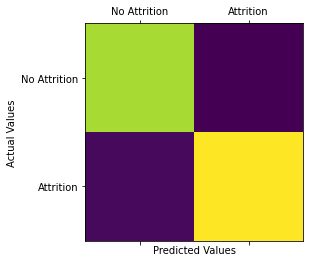

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

AUC - Test Set: 86.83%


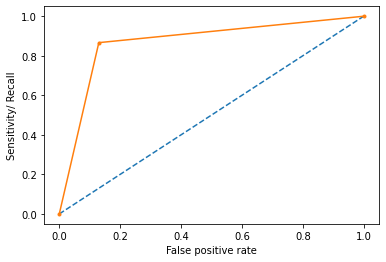

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(y_test, y_pred)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show()